# Prediction of Mackey-Glass time series

**Rafael A. Mayer, Sept. 2022**

Summary:

We applied linear regression and extreme machine learning to predict the Mackey-Glass time series.

## Importing Libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

## EDA

In [8]:
df = pd.read_csv("mackeyglass.csv")

<Axes: xlabel='t', ylabel='p'>

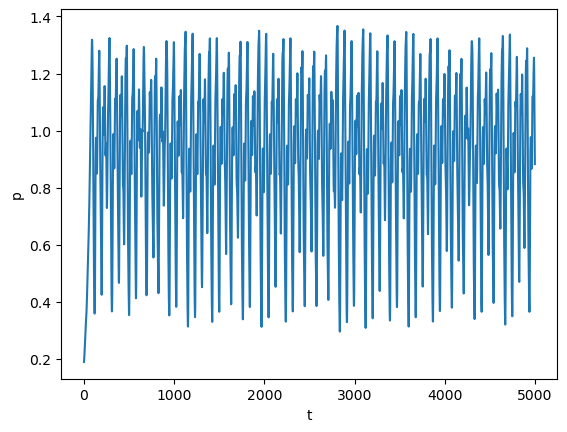

In [9]:
sns.lineplot(x = 't', y = 'p', data = df)

(0.0, 500.0)

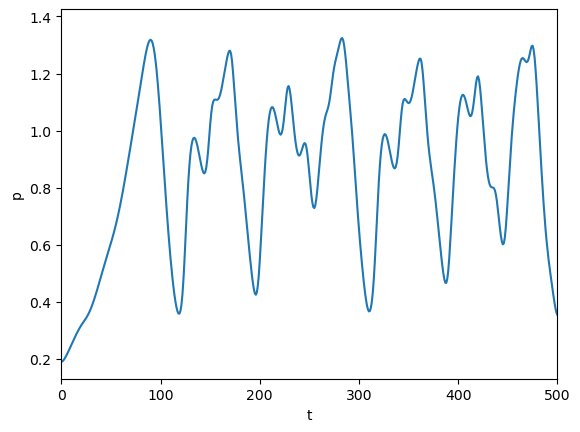

In [10]:
sns.lineplot(x = 't', y = 'p', data = df)
plt.xlim(0,500)

## Linear regression
We want to predict for a horizon of L=7, using cross-validation and checking what is the optimal number of data points for the prediction (K).

In [11]:
train, test = train_test_split(df, test_size=0.15,shuffle=False)

Cross-validation cannot be done as demonstrated in class because it is necessary to respect the temporal dependency of the data. There are two other methods, "Time Series Split Cross-Validation", which gradually increases the number of K, and "Blocked Cross-Validation" which is for a fixed k. As we want to observe the influence of K, we will do the second option. I modified X's code to incorporate revision of L = 7 elements.

In [12]:
def Block_Cross_Val_K(X,K,L):
    n_samples = len(X)
    indices = np.arange(n_samples)
    n_splits = (n_samples - K - L +1 )// K
    
    idx_train = []
    idx_val = []
    
    for i in range(n_splits):
        start = i*K 
        stop = start + K
        idx_train.append(indices[start: stop])
        
        start = stop + L - 1
        stop = start + 1
        idx_val.append(indices[start: stop])
    return idx_train,idx_val

In [13]:
def Block_Cross_Val_K_sequenced(X,K,L):
    n_samples = len(X)
    indices = np.arange(n_samples)
    
    idx_train = []
    idx_val = []
    
    for i in range(n_samples - K - L+1):
        start = i 
        stop = start + K
        idx_train.append(indices[start: stop])
        
        start = stop + L - 1
        stop = start + 1
        idx_val.append(indices[start: stop])
    return idx_train,idx_val

Vector X will have dimension K, and the vector i_val will have dimension 1, L-1 ahead of the last element of

In [14]:
K = 5
L = 7
i_train, i_val = Block_Cross_Val_K(train,K,L)

In [16]:
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train.loc[i_train[idx], ['p']])
    y_train.append(train.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

In [17]:
ts_cv = TimeSeriesSplit(n_splits=3)
all_splits = list(ts_cv.split(X_train_df, y_train_df))

Setting up the model

In [18]:
# Training data
X = X_train_df.iloc[all_splits[1][0]]  # ps
y = y_train_df.iloc[all_splits[1][0]]  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:

X_val = X_train_df.iloc[all_splits[1][1]] 
Y_val = y_train_df.iloc[all_splits[1][1]]  # target

y_pred = pd.DataFrame(model.predict(X_val), index=X_val.index,columns=['Predicted'])
RMSE = np.sqrt(np.mean((np.array(Y_val['Target'])-np.array(y_pred['Predicted']))**2))

In [20]:
y_pred.size

211

In [21]:
RMSE

0.06066037997177583

In [22]:
model.coef_

array([[  31.48585995, -148.3939402 ,  269.73010246, -225.83717175,
          73.87533929]])

Doing cross validation:

In [23]:
def Time_cross_val(model,X,y,n_splits,normalized,mean,std):
    scoring = np.zeros(n_splits)
    
    ts_cv = TimeSeriesSplit(n_splits=n_splits)
    all_splits = list(ts_cv.split(X, y))
    
    for a in range(n_splits):
        X_train_df = X.iloc[all_splits[a][0]]  # trainin X
        y_train_df = y.iloc[all_splits[a][0]]  # target training
        
        X_val = X.iloc[all_splits[a][1]] #validation X
        Y_val = y.iloc[all_splits[a][1]]  # validation target
        
        model_intern = model # to not keep fitting the same model
        
        model_intern.fit(X_train_df, y_train_df)
        y_pred = pd.DataFrame(model_intern.predict(X_val), index=X_val.index,columns=['Predicted'])
        
        if(normalized==False):
            RMSE = np.sqrt(np.mean((np.array(Y_val['Target'])-np.array(y_pred['Predicted']))**2))
        else:
            y_pred_backmap = np.array(y_pred['Predicted'])*std + mean
            Y_val_backmap = np.array(Y_val['Target'])*std + mean
            RMSE = np.sqrt(np.mean((Y_val_backmap-y_pred_backmap)**2))
        scoring[a] = RMSE
    
    return scoring

In [24]:
Time_cross_val(LinearRegression(),X_train_df,y_train_df,5,False,0,0)

array([0.0639266 , 0.06378659, 0.05996983, 0.06122813, 0.0630002 ])

Now, let's optimize K!

In [25]:
%%time
n_splits = 5
K_vec = np.linspace(1,50,50).astype('int')
S = []

for K in K_vec:
    L = 7
    i_train, i_val = Block_Cross_Val_K(train,K,L)
    X_train = []
    y_train = []
    for idx in range(len(i_train)):
        X_train.append(train.loc[i_train[idx], ['p']])
        y_train.append(train.loc[i_val[idx], ['p']])

    cols = ['K_' + str(idx) for idx in range(K)]
    X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
    y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])
        
    scores = Time_cross_val(LinearRegression(),X_train_df,y_train_df,n_splits,False,0,0)
    S.append(scores)

CPU times: total: 42.4 s
Wall time: 44.3 s


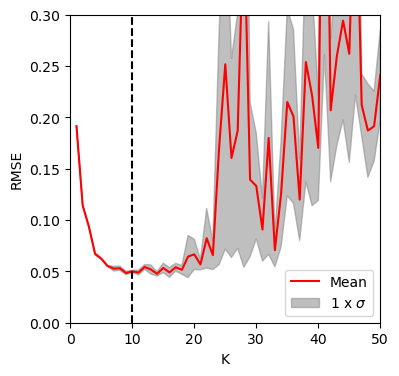

In [26]:
plt.figure(figsize=(4,4))
plt.plot(K_vec,np.mean(S,axis=1),color='red',label='Mean',ls='-')
plt.fill_between(K_vec, np.mean(S,axis=1) - np.std(S,axis=1)/2, np.mean(S,axis=1) + np.std(S,axis=1)/2,
                 color='gray', alpha=0.5,label='1 x $\sigma$')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.axvline(x=10,ls='--',color='black')
plt.xlim(0,50)
plt.ylim(0,0.3)
plt.legend()
plt.show()

K = 10 optimizes the RMSE. After that, the curve starts to get noisy and even grow. The growth is expressed by an over-adjustment of the model parameters.

Treining with the whole training+validation data set with K=10

In [27]:
K = 10
L = 7
i_train, i_val = Block_Cross_Val_K(train,K,L)
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train.loc[i_train[idx], ['p']])
    y_train.append(train.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

model = LinearRegression()
model.fit(X_train_df, y_train_df)

LinearRegression()

In [28]:
test_t = np.array(test['t'])
test_p = np.array(test['p'])

whole_t = np.array(df['t'])
whole_p = np.array(df['p'])

In [29]:
def prediction_LR(X,coef,bias,L,K):
    p = np.zeros(X.size-L-K+1)
    for i in range(p.size):
        p[i] = X[i:i+K] @ coef + bias 
    return p

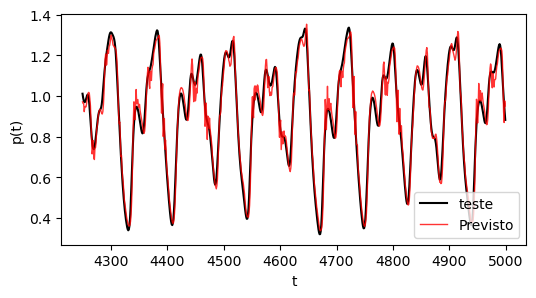

In [30]:
y_predicted_whole = prediction_LR(whole_p,np.array(model.coef_[0]),model.intercept_[0],L,K)
y_pred_cut = y_predicted_whole[df['t'].size-test_t.size-L-K+1:]

plt.figure(figsize=(6,3),dpi=100)
plt.plot(test_t,test_p,label='teste',color='black')
plt.plot(whole_t[df['t'].size-test_t.size:],y_pred_cut,label='Previsto',color='red',ls='-',alpha=0.8,lw=1)
plt.xlabel('t')
plt.ylabel('p(t)')
plt.legend()
#plt.xlim(4250,5000)
plt.show()

In [32]:
np.sqrt(np.mean((test_p-y_pred_cut)**2))

0.047815784282446046

It looks our model works very well already. Let's try something more sophisticated.

## Part 2

Agora vamos aplicar a transformação não linear dos dados de entrada da seguinte forma:

$ \vec{x}^{new}_k = tanh( \vec{w}^T_k  \vec{x}^{old}) $

For \( k = 1, \dots, V \), \( n = 0, \dots, N - 1 \), where \( N \) denotes the number of samples in the dataset. The vectors \( \vec{w}_k \) have their elements generated randomly according to a uniform distribution. We will use \( K = 10 \).

Let's generate first the data $\vec{x}^{old}$ with $K = 10$.

In [34]:
train_n = (train-train.mean())/train.std()

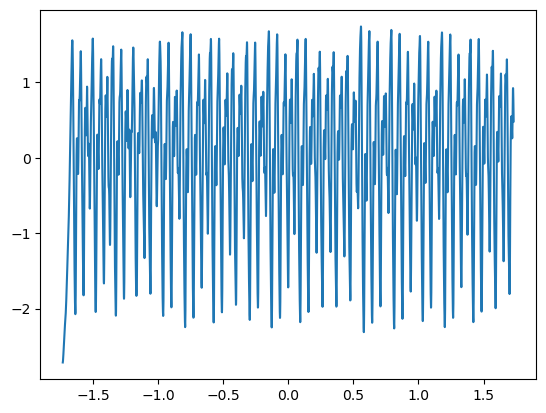

In [35]:
plt.plot(train_n['t'],train_n['p'])

In [36]:
%%time
K = 10
L = 7
i_train, i_val = Block_Cross_Val_K(train_n,K,L)
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train.loc[i_train[idx], ['p']])
    y_train.append(train.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

CPU times: total: 859 ms
Wall time: 901 ms


Now we write the non-linear mapping

In [37]:
def non_linear_map(X,V,low,high):
    X_f = np.zeros(V)
    for i in range(V):
        w_vec = np.random.uniform(low,high,size=X.size)
        X_f[i] = np.tanh(w_vec @ X)
    return X_f

In [38]:
V = 10
low = -0.5
high = 0.5

new_X = np.zeros(X_train_df.shape[0]*V).reshape(X_train_df.shape[0],V)

for row in range(X_train_df.shape[0]):
    xx = np.array(X_train_df.iloc[row,:])
    new_X[row] = non_linear_map(xx,V,low,high)
    
cols = ['V_' + str(idx) for idx in range(V)]
new_X_df = pd.DataFrame(np.array(new_X)[:,:],columns=cols)

This is the mapped dataframe.

In [39]:
new_X_df.tail()

,V_0,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9
418,-0.410732,0.958074,0.719794,-0.120661,-0.150626,0.596823,-0.575198,0.974258,-0.034946,-0.775496
419,0.831354,-0.365918,0.129627,-0.798272,0.811902,0.270969,0.653558,0.932510,0.406797,0.832638
420,0.562063,0.160230,0.432661,0.671920,-0.229671,0.309668,0.069215,0.269032,-0.033805,-0.527202
421,-0.120174,-0.114915,-0.506611,0.422427,-0.509911,-0.517816,0.282566,0.119426,-0.097809,0.001966
422,0.422460,0.362942,0.597837,0.492770,-0.489022,0.909133,-0.543338,-0.604793,-0.433364,0.878931


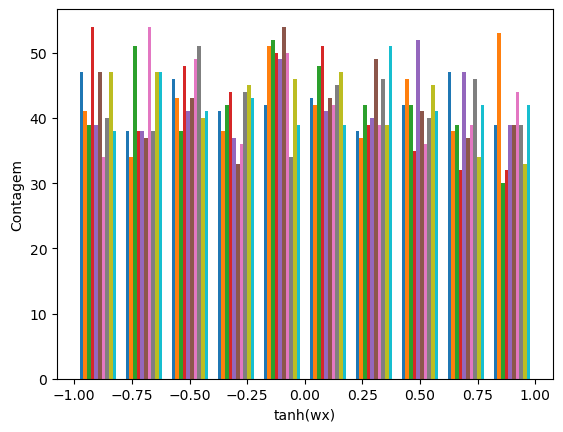

In [40]:
plt.hist(new_X_df)
plt.xlabel('tanh(wx)')
plt.ylabel('Contagem')
plt.show()

In [41]:
alpha = 1e-15 #Peso para ridge regression
n_splits = 5 #Número de coleções de amostras para vaidação cruzada

Time_cross_val(Ridge(alpha),new_X_df,y_train_df,5, True, train['p'].mean(),train['p'].std())

array([0.07658469, 0.07048868, 0.06856584, 0.07091424, 0.06780249])

### Modelando pra esse exemplo:

Utilizando o mesmo esquema de valida¸c˜ao cruzada, juntamente com a t´ecnica ridge regression para a regulariza¸c˜ao
do modelo1:

• Apresente o gr´afico com os valores de RMSE do preditor em fun¸c˜ao do n´umero de atributos (V ) utilizados,
desde V = 1 a V = 100. Neste caso, considere K = 10 (n´umero de atrasos presentes no vetor x(n)).

In [435]:
### Parametros

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 50 #Número de parametros novos mapeados
alpha = 1e-5 #Peso para ridge regression
low = -1 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 1 #Limite superior para dist. uniforme (geração do mapeamento)
n_splits = 5 #Número de coleções de amostras para vaidação cruzada

# Gerando dados com x inicial

i_train, i_val = Block_Cross_Val_K(train_n,K,L)
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train_n.loc[i_train[idx], ['p']])
    y_train.append(train_n.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

# Gerando X mapeado
new_X = []
W_

for i in range(V):
    w_random = np.random.uniform(low,high,size=X_train_df.shape[1])
    W_.append(w_random)
    atribute = np.tanh(w_random @ np.array(X_train_df).T)
    new_X.append(atribute)

new_X = np.array(new_X).T
cols = ['V_' + str(idx) for idx in range(V)]
new_X_df = pd.DataFrame(np.array(new_X)[:,:],columns=cols)

model = Ridge(alpha)

scores = Time_cross_val(model,new_X_df,y_train_df,n_splits, True, train['p'].mean(),train['p'].std())

print(scores.mean())

0.0631662756850456


In [444]:
### Parametros

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 50 #Número de parametros novos mapeados
alpha = 1e-5 #Peso para ridge regression
low = -1 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 1 #Limite superior para dist. uniforme (geração do mapeamento)
n_splits = 5 #Número de coleções de amostras para vaidação cruzada

# Gerando dados com x inicial

i_train, i_val = Block_Cross_Val_K(train_n,K,L)
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train_n.loc[i_train[idx], ['p']])
    y_train.append(train_n.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

# Gerando X mapeado

new_X_df, W_ = non_linear_map_v2(X_train_df,V,low,high)

model = Ridge(alpha)

scores = Time_cross_val(model,new_X_df,y_train_df,n_splits, True, train['p'].mean(),train['p'].std())

print(scores.mean())

0.06652276108518007


In [616]:
def non_linear_map_v2(X,V,low,high):
    new_X = []
    W_ = []

    for i in range(V):
        w_random = np.random.uniform(low,high,size=X.shape[1])
        W_.append(w_random)
        atribute = np.tanh(w_random @ np.array(X).T)
        new_X.append(atribute)

    new_X = np.array(new_X).T
    cols = ['V_' + str(idx) for idx in range(V)]
    new_X_df = pd.DataFrame(np.array(new_X)[:,:],columns=cols)
    return new_X_df,np.array(W_)

In [631]:
def non_linear_map_with_W(X,V,low,high,W):
    new_X = []
    
    for i in range(V):
        atribute = np.tanh(W[i] @ np.array(X).T)
        new_X.append(atribute)

    new_X = np.array(new_X).T
    cols = ['V_' + str(idx) for idx in range(V)]
    new_X_df = pd.DataFrame(np.array(new_X)[:,:],columns=cols)
    return new_X_df

### Vamos fazer uma função disso pra facilitar

In [617]:
def Super_model_ridge(X,K,L,V,alpha,low,high,kfold,Normalized,mean,std):
    i_train, i_val = Block_Cross_Val_K(X,K,L)
    X_train = []
    y_train = []
    for idx in range(len(i_train)):
        X_train.append(X.loc[i_train[idx], ['p']])
        y_train.append(X.loc[i_val[idx], ['p']])

    cols = ['K_' + str(idx) for idx in range(K)]
    X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
    y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

    # Gerando X mapeado

    new_X_df, W_ = non_linear_map_v2(X_train_df,V,low,high)
    
    model = Ridge(alpha)
    
    scores = Time_cross_val(model,new_X_df,y_train_df,n_splits, Normalized, mean,std)
    return scores

In [618]:
%%time
### Parametros

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 100 #Número de parametros novos mapeados
alpha =1e-5 #Peso para ridge regression
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)
nsplits = 5 #Número de coleções de amostras para vaidação cruzada

S = Super_model_ridge(train_n,K,L,V,alpha,low,high,nsplits,True,train['p'].mean(),train['p'].std())

print(S)

[0.07336773 0.04144478 0.04046416 0.03646796 0.02841908]
CPU times: total: 1.06 s
Wall time: 920 ms


## Para K = 10, vamos otimizar alpha

In [620]:
S_mean = []
S_std = []

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 200 #Número de parametros novos mapeados
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)
kfold = 5 #Número de coleções de amostras para vaidação cruzada

for alpha in np.logspace(-10,5,num=21,base=10):
    S = Super_model_ridge(train_n,K,L,V,alpha,low,high,kfold,True,train['p'].mean(),train['p'].std())
    S_mean.append(np.mean(S))
    S_std.append(np.std(S))

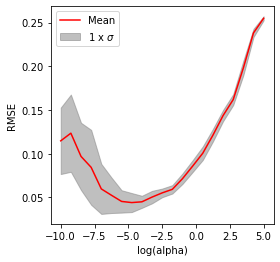

In [621]:
plt.figure(figsize=(4,4))
plt.plot(np.log10(np.logspace(-10,5,num=21,base=10)),S_mean,color='red',label='Mean')
plt.fill_between(np.log10(np.logspace(-10,5,num=21,base=10)), S_mean - np.array(S_std)/2, S_mean + np.array(S_std)/2,
                 color='gray', alpha=0.5,label='1 x $\sigma$')
plt.xlabel('log(alpha)')
plt.ylabel('RMSE')
#plt.axvline(x=9,ls='--',color='black')
#plt.xlim(0,1)
plt.legend()
plt.show()

## Fixando alpha em 1e-4 e analisando V

In [622]:
%%time
S_mean = []
S_std = []

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
alpha = 1e-4
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)
kfold = 5 #Número de coleções de amostras para vaidação cruzada

vec_range = np.concatenate([np.linspace(1,100,15).astype('int'),np.linspace(100,1000,10).astype('int')])

for V in vec_range:
    S = Super_model_ridge(train_n,K,L,V,alpha,low,high,kfold,True,train['p'].mean(),train['p'].std())
    S_mean.append(np.mean(S))
    S_std.append(np.std(S))

CPU times: total: 38.2 s
Wall time: 23.3 s


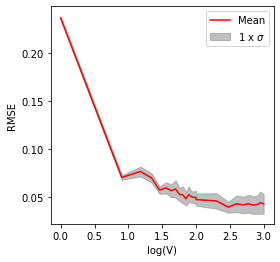

In [623]:
plt.figure(figsize=(4,4))
plt.plot(np.log10(vec_range),S_mean,color='red',label='Mean')
plt.fill_between(np.log10(vec_range), S_mean - np.array(S_std)/2, S_mean + np.array(S_std)/2,
                 color='gray', alpha=0.5,label='1 x $\sigma$')
plt.xlabel('log(V)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Variando alpha e V

In [474]:
K = 10 #Número de parametros
L = 7 #Horizonte de previsão
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)
kfold = 5 #Número de coleções de amostras para vaidação cruzada

V = np.logspace(0,3,num=10,base=10).astype('int')
alpha = np.logspace(-10,5,num=10,base=10)

S_mean = np.zeros(V.size*alpha.size).reshape(V.size,alpha.size)
S_std = np.zeros(V.size*alpha.size).reshape(V.size,alpha.size)


for i in range(V.size):
    for j in range(alpha.size):
        S = Super_model_ridge(train_n,K,L,V[i],alpha[j],low,high,kfold,True,train['p'].mean(),train['p'].std())
        S_mean[i,j]=np.mean(S)
        S_std[i,j]=np.std(S)

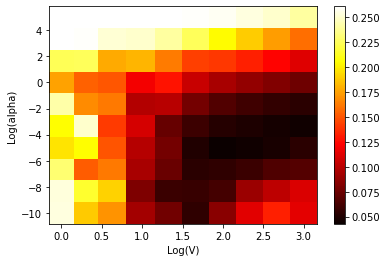

In [475]:
VV,AA = np.meshgrid(np.log10(V),np.log10(alpha))

plt.figure()
plt.pcolormesh(VV,AA,S_mean.T,cmap='hot')
plt.xlabel('Log(V)')
plt.ylabel('Log(alpha)')
plt.colorbar()
plt.show()

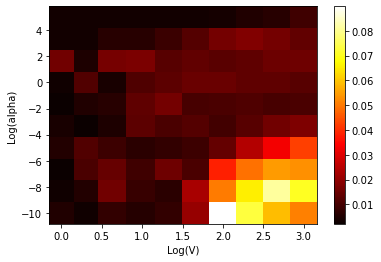

In [476]:
VV,AA = np.meshgrid(np.log10(V),np.log10(alpha))

plt.figure()
plt.pcolormesh(VV,AA,S_std.T,cmap='hot')
plt.xlabel('Log(V)')
plt.ylabel('Log(alpha)')
plt.colorbar()
plt.show()

In [480]:
np.where(S_mean == np.min(S_mean))

(array([6], dtype=int64), array([3], dtype=int64))

In [481]:
S_mean[6,3]

0.04278590402907727

### Best Parameters

In [483]:
print('V = '+str(V[6]))
print("alpha = "+str(alpha[3]) )

V = 100
alpha = 1e-05


In [546]:
K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 100 #Número de parametros novos mapeados
alpha =1e-5 #Peso para ridge regression
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)
nsplits = 5 #Número de coleções de amostras para vaidação cruzada

S = Super_model_ridge(train_n,K,L,V,alpha,low,high,nsplits,True,train['p'].mean(),train['p'].std())

print(str(round(np.mean(S),4)) +' +- ' + str(round(np.std(S),4)))

0.0411 +- 0.0123


## Prediction with new model

In [624]:
### Parametros

K = 10 #Número de parametros
L = 7 #Horizonte de previsão
V = 100 #Número de parametros novos mapeados
alpha = 1e-5 #Peso para ridge regression
low = -0.5 #Limite inferior para dist. uniforme (geração do mapeamento)
high = 0.5 #Limite superior para dist. uniforme (geração do mapeamento)

# Gerando dados com x inicial

i_train, i_val = Block_Cross_Val_K(train_n,K,L)
X_train = []
y_train = []
for idx in range(len(i_train)):
    X_train.append(train_n.loc[i_train[idx], ['p']])
    y_train.append(train_n.loc[i_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_train_df = pd.DataFrame(np.array(X_train)[:,:,0],columns=cols)
y_train_df = pd.DataFrame(np.array(y_train)[:,0,0],columns=['Target'])

# Gerando X mapeado
new_X_df, W_ = non_linear_map_v2(X_train_df,V,low,high)

model_RR = Ridge(alpha)

model_RR.fit(new_X_df,y_train_df)

Ridge(alpha=1e-05)

In [627]:
W_.shape

(100, 10)

In [632]:
# Gerando dados com x inicial

df_norm = (df-train.mean())/train.std()

i_df, i_df_val = Block_Cross_Val_K_sequenced(df_norm,K,L)
X_df = []
y_df = []
for idx in range(len(i_df)):
    X_df.append(df_norm.loc[i_df[idx], ['p']])
    y_df.append(df_norm.loc[i_df_val[idx], ['p']])

cols = ['K_' + str(idx) for idx in range(K)]
X_df_df = pd.DataFrame(np.array(X_df)[:,:,0],columns=cols)
y_df_df = pd.DataFrame(np.array(y_df)[:,0,0],columns=['Target'])

# Gerando X mapeado
new_df = non_linear_map_with_W(X_df_df,V,low,high,W_)

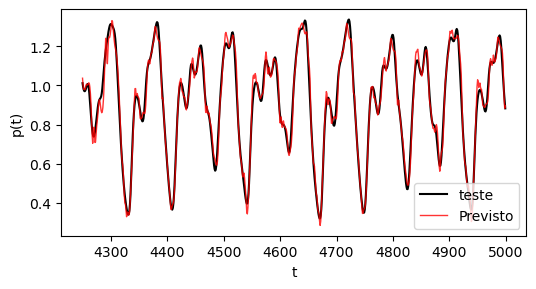

In [634]:
y_predicted_whole = model_RR.predict(new_df)*train['p'].std() + train['p'].mean()

y_pred_cut = y_predicted_whole[df['t'].size-test_t.size-L-K+1:]

plt.figure(figsize=(6,3),dpi=100)
plt.plot(test_t,test_p,label='teste',color='black')
plt.plot(whole_t[df['t'].size-test_t.size:],y_pred_cut,label='Previsto',color='red',ls='-',alpha=0.8,lw=1)
plt.xlabel('t')
plt.ylabel('p(t)')
plt.legend()
#plt.xlim(4250,5000)
plt.show()

In [655]:
RMSE = np.sqrt(np.mean((test_p-y_pred_cut[:,0])**2))
print(RMSE)

0.035524655703516574


## References:
https://goldinlocks.github.io/Time-Series-Cross-Validation/

https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

https://www.kaggle.com/code/alexisbcook/cross-validation